# Difc calculation using scipy


In [44]:
workdir = "/SNS/users/lj7/dv/sns-chops/detcalib/SEQ"
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/detcalib/SEQ


In [1]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import os, numpy as np
from mantid import simpleapi as msa, mtd

In [3]:
dvalues = [1.10860231, 1.24596143, 1.357755, 1.63751414, 1.92015553, 3.13560085]

In [4]:
%%time
ws = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5')

CPU times: user 1min 19s, sys: 43.6 s, total: 2min 3s
Wall time: 5min 33s


In [5]:
%%time
ws = msa.CropWorkspace(InputWorkspace=ws, XMin=300, XMax=16666.7)

CPU times: user 5min 23s, sys: 28min 20s, total: 33min 44s
Wall time: 1min 31s


## Compute nominal difc

In [6]:
difc = msa.CalculateDIFC(InputWorkspace=ws)

In [7]:
difc = difc.extractY().flatten()

# Use nominal values to convert to I(d)

In [8]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=ws, Target='dSpacing', EMode='Elastic')

CPU times: user 17.5 s, sys: 18.8 s, total: 36.3 s
Wall time: 36.3 s


In [9]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='0.4,0.005,7')

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 161 ms


# Get pack index

In [10]:
instrument = ws.getInstrument()

In [11]:
pack = instrument.getComponentByName("D6/eightpack")

In [12]:
firstpixel = pack[0][0].getID()
firstpixel

120832

In [13]:
lasttube = pack[pack.nelements()-1]
lastpixel = lasttube[lasttube.nelements()-1]
lastpixel = lastpixel.getID()
lastpixel

121855

In [14]:
detIDs = []
for i in range(ws.getNumberHistograms()):
    sp = ws.getSpectrum(i)
    dets = list(sp.getDetectorIDs())
    assert len(dets)==1
    detIDs.append(dets[0])
    continue

In [15]:
for i in range(len(detIDs)-1):
    assert detIDs[i] < detIDs[i+1]

In [16]:
startindex = detIDs.index(firstpixel)
endindex = detIDs.index(lastpixel)
startindex, endindex

(82944, 83967)

In [17]:
I_d_D6 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=startindex, EndWorkspaceIndex=endindex)

<IPython.core.display.Javascript object>


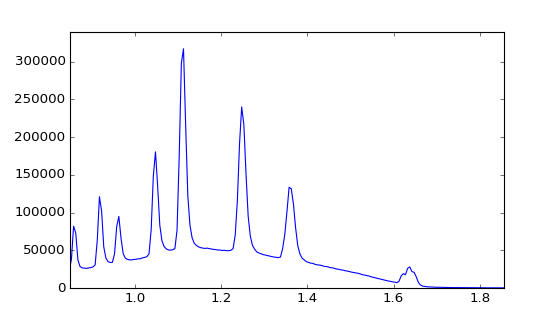

(0, 3.8)

In [18]:
plt.figure(figsize=(7,4))
Xbb = I_d_D6.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_D6.readY(0))
plt.xlim(0,3.8)

In [19]:
startindex+60

83004

In [20]:
I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=startindex+60, EndWorkspaceIndex=startindex+60)

<IPython.core.display.Javascript object>


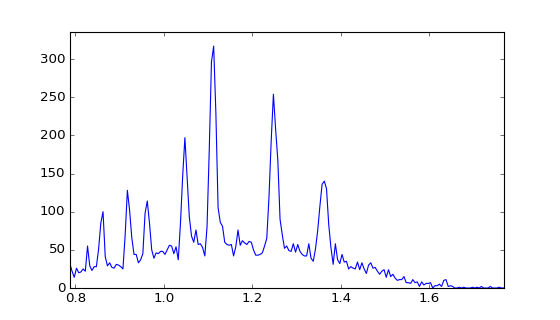

(0, 3.8)

In [21]:
plt.figure(figsize=(7,4))
Xbb = I_d_pixel.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_pixel.readY(0))
plt.xlim(0,3.8)

Simple fitting

In [22]:
import scipy.optimize as sopt

In [23]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [24]:
def gauss_with_bg(x, *p):
    A, mu, sigma, bg = p
    return bg + A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [25]:
x = (Xbb[:-1]+Xbb[1:])/2
y = I_d_pixel.readY(0)

In [26]:
np.where(x>1.2)[0][0], np.where(x<1.3)[0][-1]

(160, 179)

In [27]:
x1 = x[160:179]
y1 = y[160:179]

<IPython.core.display.Javascript object>


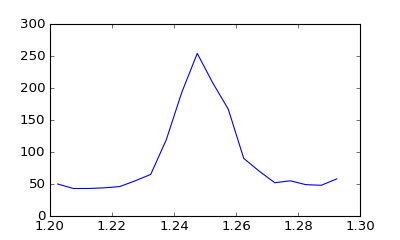

In [28]:
plt.figure(figsize=(5,3))
plt.plot(x1,y1)

In [29]:
popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=(160, 1.25, 0.01, 20))
print popt

[  1.96755241e+02   1.24878685e+00   7.95291026e-03   4.86598559e+01]


<IPython.core.display.Javascript object>


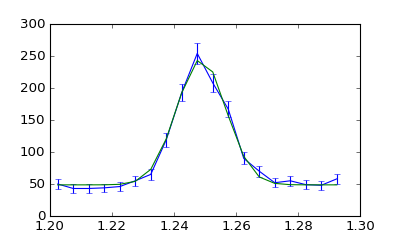

In [30]:
plt.figure(figsize=(5,3))
plt.errorbar(x1, y1, yerr=np.sqrt(y1))
plt.plot(x1, gauss_with_bg(x1, *popt))

goodness of fit?

In [31]:
chisq = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)

In [32]:
chisq

0.48876945096330865

In [33]:
difc[2108]

6036.2127662669545

new difc

In [34]:
difc[2108]*popt[1]/1.24596143

6049.9008714869306

## Loop over all pixels in D23

In [35]:
N = I_d.getNumberHistograms()

In [36]:
maxchisq = 3.
min_counts = 200 # at least this many counts per peak

In [38]:
newdifc = difc.copy()

mask = np.zeros(difc.shape, dtype=bool)
chisq = np.zeros((len(dvalues),) + difc.shape, dtype=float)
peaks = np.zeros((len(dvalues),) + difc.shape, dtype=float)

In [39]:
firstindex, lastindex = startindex, endindex

In [40]:
%%time

for pixel in range(firstindex, lastindex+1):
# for pixel in range(firstindex+0, firstindex+1):
    if (pixel%100)==0 : print pixel
    # print pixel
    I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=pixel, EndWorkspaceIndex=pixel)
    Xbb = I_d_pixel.readX(0)
    x = (Xbb[:-1]+Xbb[1:])/2
    y = I_d_pixel.readY(0)
    peaks_thispixel = peaks[:, pixel]
    for pkindex, d0 in enumerate(dvalues):
        dmin = d0*.96
        dmax = d0*1.04
        startindex, stopindex = np.where(x>dmin)[0][0], np.where(x<dmax)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        if np.sum(y1) < min_counts:
            peaks_thispixel[pkindex] = np.nan
            continue
        # print x1
        # print y1
        guess_center = x1[np.argmax(y1)]
        startindex, stopindex = np.where(x>guess_center-0.05*d0)[0][0], np.where(x<guess_center+0.05*d0)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        bg = (y1[0]+y1[-1])/2
        p0 = np.max(y1)-bg, guess_center, 0.01, bg
        # print "p0=",p0
        # print x1
        # print y1
        try:
            popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=p0)
        except:
            peaks_thispixel[pkindex] = np.nan
            continue
        # print "popt=", popt
        chisq1 = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)
        chisq[pkindex, pixel] = chisq1
        # print "chisq=", chisq1
        if chisq1 > maxchisq:
            peaks_thispixel[pkindex] = np.nan
            continue
        peaks_thispixel[pkindex] = popt[1]
        continue
    Ngoodfit = np.sum(np.isfinite(peaks_thispixel))
    # print Ngoodfit
    if not Ngoodfit:
        mask[pixel] = 1
        continue
    ratios = peaks_thispixel / dvalues
    # print "ratios=", ratios
    good_ratios = ratios[np.isfinite(ratios)]
    # print "good_ratios=", good_ratios
    average_ratio = np.average(good_ratios)
    newdifc[pixel] = difc[pixel] * average_ratio
    # print average_ratio
    # break
    continue

/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning:

divide by zero encountered in divide



83000
83100
83200
83300
83400
83500
83600
83700
83800
83900
CPU times: user 1min 44s, sys: 1.88 s, total: 1min 46s
Wall time: 1min 46s


In [41]:
tube=2
tube_slice = slice(firstindex+128*tube, firstindex+128*(tube+1))
newdifc[tube_slice]/difc[tube_slice]

array([ 1.        ,  1.        ,  0.99909977,  1.0001296 ,  1.00099992,
        1.00028322,  1.00080876,  1.00072036,  1.00056079,  1.00022766,
        1.0003938 ,  1.0005651 ,  1.0006649 ,  1.00057986,  1.00052799,
        1.00024522,  1.00075081,  1.00071652,  1.00080781,  1.00084515,
        1.00095702,  1.00174809,  1.00085026,  1.00117764,  1.00090814,
        1.00070279,  1.00114529,  1.00112815,  1.0011608 ,  1.00087529,
        1.00146528,  1.00091796,  1.00119089,  1.00155073,  1.00083374,
        1.00123071,  1.00127438,  1.00115287,  1.0010611 ,  1.00152105,
        1.00144581,  1.00082755,  1.00139502,  1.00138198,  1.00133203,
        1.00130607,  1.00171145,  1.00169669,  1.00199341,  1.00201567,
        1.001471  ,  1.00088364,  1.00162021,  1.00189035,  1.00200958,
        1.00209025,  1.0021833 ,  1.0022801 ,  1.00174981,  1.00170516,
        1.00226257,  1.00195125,  1.00195345,  1.00219161,  1.00236197,
        1.00248251,  1.00247599,  1.00210734,  1.00240085,  1.00

# Check aligned I(d)

In [45]:
t = msa.Load('./difc_cal.nxs')

In [46]:
t.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [47]:
tzero = np.array(t.column('tzero'))

In [48]:
np.all(tzero==0)

True

In [49]:
for i, v in enumerate(newdifc):
    t.setCell('difc', i, v)
    continue

In [50]:
%%time
aligned = msa.AlignDetectors(InputWorkspace=ws, CalibrationWorkspace=t)

CPU times: user 1min 42s, sys: 59.1 s, total: 2min 41s
Wall time: 45.7 s


In [51]:
%%time
aligned = msa.CropWorkspace(InputWorkspace='aligned', XMin=0.4, XMax=7)

CPU times: user 3min 43s, sys: 9min 27s, total: 13min 10s
Wall time: 26.5 s


In [61]:
%%time
I_d_aligned = msa.Rebin(InputWorkspace=aligned, Params='0.4,0.005,7')

CPU times: user 8.54 s, sys: 14.7 s, total: 23.3 s
Wall time: 23.3 s


In [62]:
I_d_pack_D6 = msa.SumSpectra(InputWorkspace=I_d_aligned, StartWorkspaceIndex=firstindex, EndWorkspaceIndex=lastindex)

<IPython.core.display.Javascript object>


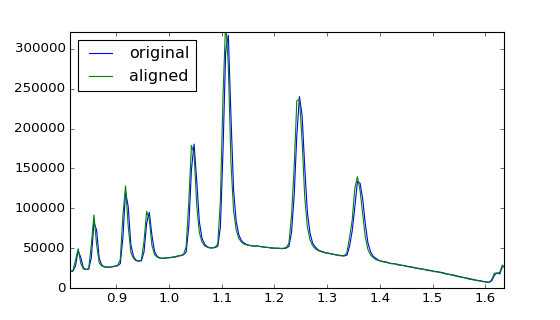

In [64]:
x_bb = I_d_pack_D6.readX(0); y = I_d_pack_D6.readY(0)
x = (x_bb[1:] + x_bb[:-1])/2
plt.figure(figsize=(7,4))
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_D6.readY(0), label='original')
plt.plot(x,y, label='aligned')
# plt.xlim(3,3.3)
plt.legend(loc='upper left')

In [104]:
np.sum(mask[firstindex:lastindex+1])

80